In [ ]:
# Install necessary libraries
#!pip install h2o ydata-profiling shap lime polars pyarrow autofeat mlflow
#!pip install -r requirements.txt
!pip install --ignore-installed -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 23.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached polars-1.6.0-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached pyarrow-14.0.2-cp310-cp310-manylinux_2_28_x86_64.whl.metadata (3.0 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached scipy-1.13.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached pydantic-2.9.2-py3-none-any.whl.metadata (149 kB)
  Using cached PyYAML-6.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import the required libraries
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lime.lime_tabular import LimeTabularExplainer
from IPython.display import display, HTML
from h2o.automl import H2OAutoML
import h2o
import shap
import ydata_profiling
import matplotlib.pyplot as plt
import os
import mlflow
import mlflow.h2o
import joblib

In [ ]:
# Function to load the Iris dataset
def load_data():
    """
    Load the Iris dataset, return it as a DataFrame.
    Returns:
        df: The Iris dataset as a DataFrame.
    """
    from sklearn.datasets import load_iris
    import pandas as pd

    iris = load_iris(as_frame=True)
    data = iris['data']
    target = iris['target']

    # Combine the data and target into one DataFrame
    df = pd.concat([data, target], axis=1)

    # Rename columns for clarity
    df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

    return df

In [ ]:
# Function to perform AutoEDA using ydata_profiling
def auto_eda(df):
    """
    Generate an automated exploratory data analysis (EDA) report using ydata_profiling.
    Args:
        df: The DataFrame for which EDA should be performed (unscaled, unengineered).
    """
    import ydata_profiling

    profile = ydata_profiling.ProfileReport(df, title="Iris Dataset AutoEDA Report")
    profile.to_file("iris_autoeda_report.html")
    print("AutoEDA report saved as 'iris_autoeda_report.html'.")

In [ ]:
# Function to clean the dataset manually using Pandas
def manual_clean(df):
    """
    Clean the dataset using manual pandas methods.
    Args:
        df: The original DataFrame.
    Returns:
        df_cleaned: The cleaned DataFrame.
    """

    # 1. Handle missing values (if any): Impute or drop missing values.
    # For the Iris dataset, we typically won't have missing values, but this step is generalizable.
    # Fill missing values with the median (if any exist).
    df.fillna(df.median(), inplace=True)

    # 2. Remove duplicates if any.
    df_cleaned = df.drop_duplicates()

    # 3. Ensure column names are lowercase (for consistency).
    df_cleaned.columns = df_cleaned.columns.str.lower()

    # 4. Convert categorical columns to appropriate types (if necessary). In this case, 'species' is categorical.
    df_cleaned['species'] = df_cleaned['species'].astype('category')

    return df_cleaned

In [ ]:
# Function to perform feature engineering using AutoFeat
def auto_feat(df):
    """
    Apply automatic feature engineering to the cleaned dataset using AutoFeat.
    Args:
        df: The cleaned DataFrame.
    Returns:
        df_engineered: The DataFrame with new engineered features.
    """
    from autofeat import AutoFeatRegressor
    import pandas as pd

    X = df.drop('species', axis=1)
    y = df['species']

    autofeat_regressor = AutoFeatRegressor(verbose=1, feateng_steps=2)
    X_enhanced = autofeat_regressor.fit_transform(X, y)

    # Reattach the target column after feature engineering
    df_engineered = pd.concat([X_enhanced, y.reset_index(drop=True)], axis=1)
    return df_engineered

In [ ]:
# Function to split and scale the data
def split_and_scale_data(df):
    """
    Split the dataset into training and test sets and apply scaling.
    Args:
        df: The feature-engineered DataFrame.
    Returns:
        X_train_scaled, X_test_scaled, y_train, y_test: Scaled training and test sets.
    """

    X = df.drop('species', axis=1)
    y = df['species']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Saving scaler for inference
    # Save the scaler to a file
    joblib.dump(scaler, 'iris_scaler.pkl')

    # Convert to pandas DataFrame after scaling
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    return X_train_scaled, X_test_scaled, y_train, y_test

In [ ]:
def preprocess_data_for_prediction(input_data):
    """
    Preprocess the data received for prediction by scaling it.
    Args:
        input_data: Raw input data (as a DataFrame) for prediction.
    Returns:
        scaled_data: Scaled and processed data ready for prediction.
    """
    # Ensure the input data has the correct columns
    required_columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
    input_data = input_data[required_columns]

    # Scaler used during training
    scaler = StandardScaler()

    # Scale the data using the scaler saved during training
    scaled_data = scaler.transform(input_data)

    # Convert scaled data back to a DataFrame for compatibility with the model
    scaled_data_df = pd.DataFrame(scaled_data, columns=required_columns)

    return scaled_data_df


In [ ]:
# Modify the train_model_with_h2o function to include MLflow tracking
def train_model_with_h2o(X_train_scaled, X_test_scaled, y_train, y_test):
    """
    Train multiple models using H2O AutoML and return the best model.
    Args:
        X_train_scaled: Scaled training feature set.
        X_test_scaled: Scaled testing feature set.
        y_train: Training target values.
        y_test: Testing target values.
    Returns:
        best_model: The best-performing model from H2O AutoML.
        X_test_scaled: Scaled testing features for SHAP interpretation.
    """
    h2o.init()

    train_data = h2o.H2OFrame(pd.concat([X_train_scaled, y_train.reset_index(drop=True)], axis=1))
    test_data = h2o.H2OFrame(pd.concat([X_test_scaled, y_test.reset_index(drop=True)], axis=1))

    train_data['species'] = train_data['species'].asfactor()
    test_data['species'] = test_data['species'].asfactor()

    target_column = 'species'
    predictors = X_train_scaled.columns.tolist()

    with mlflow.start_run() as run:
        automl = H2OAutoML(max_models=20, seed=1, verbosity='info', sort_metric = "accuracy")  #, max_runtime_secs=60, max_runtime_secs_per_model=10)
        automl.train(x=predictors, y=target_column, training_frame=train_data)

        # Log leaderboard and best model using MLflow
        leaderboard = automl.leaderboard
        best_model = automl.leader

        print("Leaderboard:\n", leaderboard)
        print("Best Model:\n", best_model)

        # Log model using MLflow H2O
        mlflow.log_param("max_models", 20)
        mlflow.h2o.log_model(best_model, artifact_path="model")

        # Retrieve and convert the leaderboard to a pandas DataFrame
        leaderboard_df = automl.leaderboard.as_data_frame()

        # Save the leaderboard to a CSV file
        leaderboard_file_path = "h2o_automl_leaderboard.csv"
        leaderboard_df.to_csv(leaderboard_file_path, index=False)

        # Log the leaderboard file as an artifact in MLflow
        mlflow.log_artifact(leaderboard_file_path)

    return best_model, X_test_scaled

In [ ]:
# Function to save the H2O model using h2o.save_model
def save_model(best_model, model_name="h2o_best_model"):
    """
    Save the best H2O model using h2o.save_model.
    Args:
        best_model: The best H2O model from H2O AutoML.
        model_name: The name for the saved model.
    Returns:
        model_path: The path where the model is saved.
    """
    # Save the model using h2o.save_model
    model_path = h2o.save_model(model=best_model, path="./", force=True)

    # Rename the model to the specified model name
    new_model_path = os.path.join("./", model_name)
    os.rename(model_path, new_model_path)

    print(f"Model saved and renamed to: {new_model_path}")

    return new_model_path

In [ ]:
# Function to make predictions using the trained H2O model
def predict_with_h2o_model(data_as_numpy_array, X_columns, best_model, return_probs=False):
    """
    Wrapper to convert data to H2OFrame and return predictions for SHAP and probabilities for LIME.
    Args:
        data_as_numpy_array: Data for prediction in numpy format.
        X_columns: Column names of the data (for DataFrame conversion).
        best_model: Trained H2O model for prediction.
        return_probs: Boolean indicating whether to return probabilities (for LIME) or class labels (for SHAP).
    Returns:
        numpy array of either class labels (for SHAP) or probability scores (for LIME).
    """
    data_as_df = pd.DataFrame(data_as_numpy_array, columns=X_columns)
    h2o_test_frame = h2o.H2OFrame(data_as_df)

    predictions = best_model.predict(h2o_test_frame)

    if return_probs:
        probability_scores = predictions.as_data_frame(use_multi_thread=True).iloc[:, 1:].values
        return probability_scores
    else:
        class_labels = predictions.as_data_frame(use_multi_thread=True).iloc[:, 0].values
        return class_labels

In [ ]:
# Function to apply SHAP for explainability
def apply_shap_explainability(best_model, X_test_scaled):
    """
    Apply SHAP to explain the model's predictions and display & save the relevant plots as PNG files.
    Args:
        best_model: The best model from H2O AutoML.
        X_test_scaled: Scaled testing feature set for SHAP interpretation.
    """
    import shap
    import pandas as pd
    import matplotlib.pyplot as plt

    X_test_shap = pd.DataFrame(X_test_scaled, columns=X_test_scaled.columns)

    explainer = shap.KernelExplainer(lambda x: predict_with_h2o_model(x, X_test_shap.columns, best_model, return_probs=False), X_test_shap)
    shap_values = explainer.shap_values(X_test_shap)

    # 1. SHAP Summary Plot (Global Feature Importance)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test_shap, show=False)  # `show=False` ensures plot is not displayed twice
    plt.savefig("shap_summary_plot.png", bbox_inches='tight')  # Ensure the whole plot is saved
    plt.show()  # Display the plot
    print("SHAP summary plot saved as 'shap_summary_plot.png'.")

    # 2. SHAP Force Plot (Local Explanation for a Single Instance)
    force_plot = shap.force_plot(explainer.expected_value, shap_values[0], X_test_shap.iloc[0, :])
    shap.save_html("shap_force_plot.html", force_plot)
    print("SHAP force plot saved as 'shap_force_plot.html'.")

    # 3. SHAP Waterfall Plot (Local Explanation for a Single Instance)
    shap_values_explanation = shap.Explanation(values=shap_values[0],
                                              base_values=explainer.expected_value,
                                              data=X_test_shap.iloc[0, :].values,
                                              feature_names=X_test_shap.columns)
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(shap_values_explanation, show=False)
    plt.savefig("shap_waterfall_plot.png", bbox_inches='tight')
    plt.show()
    print("SHAP waterfall plot saved as 'shap_waterfall_plot.png'.")

    # 4. SHAP Dependence Plot (Feature Interaction Insights)
    plt.figure(figsize=(10, 6))
    shap.dependence_plot("petal_length", shap_values, X_test_shap, interaction_index="petal_width", show=False)
    plt.savefig("shap_dependence_plot.png", bbox_inches='tight')
    plt.show()
    print("SHAP dependence plot saved as 'shap_dependence_plot.png'.")

    # 5. SHAP Decision Plot (Cumulative Feature Impact)
    plt.figure(figsize=(10, 6))
    shap.decision_plot(explainer.expected_value, shap_values, X_test_shap, show=False)
    plt.savefig("shap_decision_plot.png", bbox_inches='tight')
    plt.show()
    print("SHAP decision plot saved as 'shap_decision_plot.png'.")

In [ ]:
# Function to apply LIME for explainability
def apply_lime_explainability(best_model, X_train_scaled, X_test_scaled, y_train):
    """
    Apply LIME to explain a single prediction from the model.
    Args:
        best_model: The best model from H2O AutoML.
        X_train_scaled: Scaled training feature set.
        X_test_scaled: Scaled testing feature set.
        y_train: Training target values.
    """
    from lime.lime_tabular import LimeTabularExplainer

    explainer = LimeTabularExplainer(
        training_data=X_train_scaled.values,
        feature_names=X_train_scaled.columns,
        class_names=[str(cls) for cls in y_train.unique()],
        mode="classification"
    )

    sample_idx = 0
    sample = X_test_scaled.iloc[sample_idx].values.reshape(1, -1)

    explanation = explainer.explain_instance(
        data_row=sample[0],
        predict_fn=lambda x: predict_with_h2o_model(x, X_train_scaled.columns, best_model, return_probs=True),
        num_features=len(X_train_scaled.columns)
    )

    explanation.save_to_file('lime_explanation.html')
    print(f"LIME explanation saved as 'lime_explanation.html' for test sample index {sample_idx}.")

In [ ]:
# Function to shut down the H2O cluster
def shutdown_h2o():
    """
    Shut down the H2O cluster after the model training is complete.
    """
    import h2o
    h2o.cluster().shutdown()
    print("H2O cluster shut down.")

In [ ]:
# Main process function to orchestrate the entire workflow
def process():
    """
    Main function to trigger the entire process:
    1. Load Data
    2. Perform AutoEDA
    3. Clean the Data
    4. Split and Scale the Data
    5. Train the Model using H2O AutoML
    6. Saving model using h2o.save_model
    7. Apply Explainability using SHAP
    8. Apply Explainability using LIME
    9. Shut down H2O Cluster
    """

    # Step 1: Load the data
    df = load_data()
    print("Data loaded.")

    # Step 2: Perform AutoEDA
    print("Performing AutoEDA...")
    auto_eda(df)
    print("AutoEDA completed.")

    # Step 3: Clean the data
    print("Cleaning the data...")
    df_cleaned = manual_clean(df)
    print("Data cleaned.")

    # # Step 4: Apply feature engineering using AutoFeat
    # print("Applying feature engineering...")
    # df_engineered = auto_feat(df_cleaned)
    # print("Feature engineering completed.")

    # Step 5: Split and scale the data
    print("Splitting and scaling the data...")
    X_train_scaled, X_test_scaled, y_train, y_test = split_and_scale_data(df_cleaned)
    print("Data split and scaled.")

    # Step 6: Train the model using H2O AutoML with MLflow tracking
    print("Training the model using H2O AutoML...")
    best_model, X_test_scaled = train_model_with_h2o(X_train_scaled, X_test_scaled, y_train, y_test)
    print("Model training completed.")

    # Step 7: Saving the model using h2o.save_model
    print("Saving the best H2O AutoML model...")
    save_model(best_model, "h2o_best_model")
    print("Model saving completed.")

    # Step 8: Apply SHAP for explainability
    print("Applying SHAP for explainability...")
    apply_shap_explainability(best_model, X_test_scaled)
    print("SHAP explainability applied.")

    # Step 9: Apply LIME for explainability
    print("Applying LIME for explainability...")
    apply_lime_explainability(best_model, X_train_scaled, X_test_scaled, y_train)
    print("LIME explainability applied.")

    # Step 10: Shut down the H2O cluster
    print("Shutting down H2O cluster...")
    shutdown_h2o()
    print("Process completed.")

Data loaded.
Performing AutoEDA...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

AutoEDA report saved as 'iris_autoeda_report.html'.
AutoEDA completed.
Cleaning the data...
Data cleaned.
Splitting and scaling the data...
Data split and scaled.
Training the model using H2O AutoML...
Checking whether there is an H2O instance running at http://localhost:54321.

<ipython-input-4-24de8f551eac>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['species'] = df_cleaned['species'].astype('category')


.... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.24" 2024-07-16; OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu322.04); OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu322.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp29dy4fbu
  JVM stdout: /tmp/tmp29dy4fbu/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp29dy4fbu/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,"28 days, 16 hours and 50 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_067fvy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
04:42:05.510: Project: AutoML_1_20240927_44205
04:42:05.512: 5-fold cross-validation will be used.
04:42:05.513: Setting stopping tolerance adaptively based on the training frame: 0.05
04:42:05.513: Build control seed: 1
04:42:05.514: training frame: Frame key: AutoML_1_20240927_44205_training_py_1_sid_9005    cols: 5    rows: 119  chunks: 1    size: 3021  checksum: -1707408784591829665
04:42:05.514: validation frame: NULL
04:42:05.514: leaderboard frame: NULL
04:42:05.514: blending frame: NULL
04:42:05.514: response column: species
04:42:05.515: fold column: null
04:42:05.515: weights column: null
04:42:05.539: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 

2024/09/27 04:50:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model training completed.
Saving the best H2O AutoML model...
Model saved and renamed to: ./h2o_best_model
Model saving completed.
Applying SHAP for explainability...
Parse progress: |

/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


  0%|          | 0/30 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |████████████████████

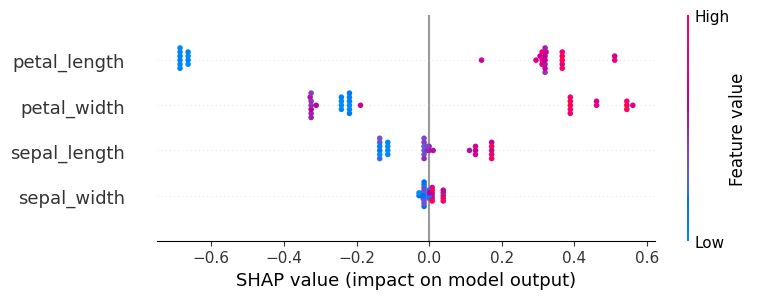

SHAP summary plot saved as 'shap_summary_plot.png'.
SHAP force plot saved as 'shap_force_plot.html'.


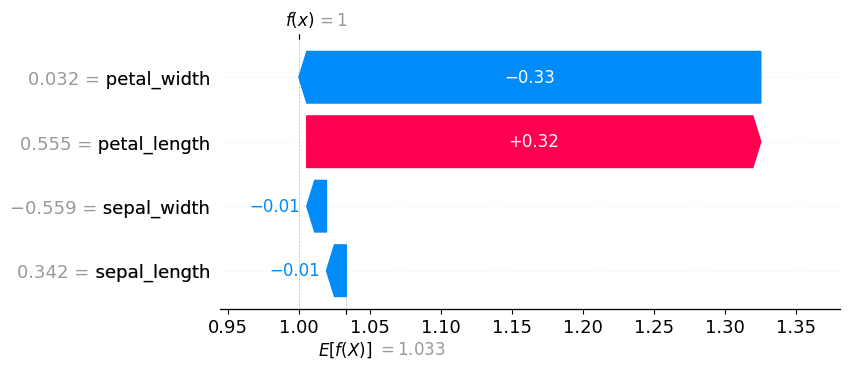

SHAP waterfall plot saved as 'shap_waterfall_plot.png'.


<Figure size 1000x600 with 0 Axes>

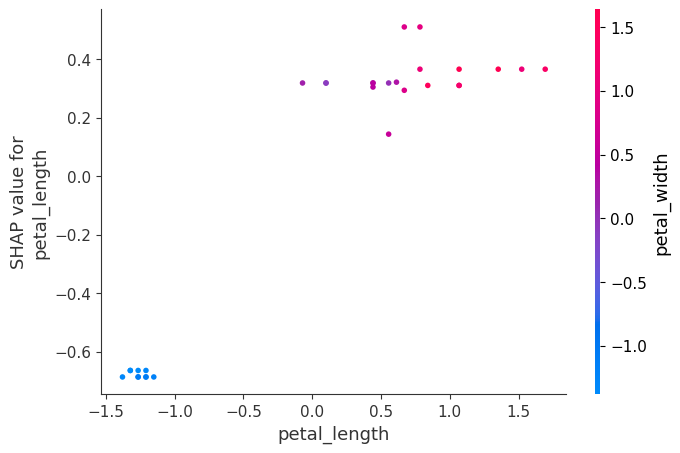

SHAP dependence plot saved as 'shap_dependence_plot.png'.


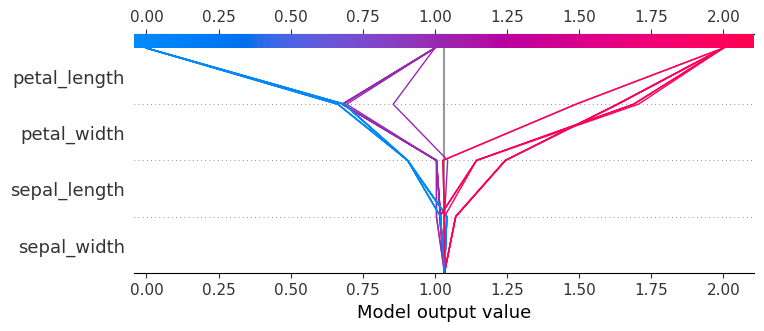

SHAP decision plot saved as 'shap_decision_plot.png'.
SHAP explainability applied.
Applying LIME for explainability...
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
LIME explanation saved as 'lime_explanation.html' for test sample index 0.
LIME explainability applied.
Shutting down H2O cluster...
H2O session _sid_9005 closed.
H2O cluster shut down.
Process completed.


In [ ]:
process()

In [ ]:
# Step 1: Load the data
df = load_data()
print("Data loaded.")

Data loaded.


In [ ]:
!zip -r mlruns.zip mlruns

  adding: mlruns/ (stored 0%)
  adding: mlruns/0/ (stored 0%)
  adding: mlruns/0/meta.yaml (deflated 24%)
  adding: mlruns/0/33d06e1acd524cf891a37f897c68a400/ (stored 0%)
  adding: mlruns/0/33d06e1acd524cf891a37f897c68a400/tags/ (stored 0%)
  adding: mlruns/0/33d06e1acd524cf891a37f897c68a400/tags/mlflow.source.name (deflated 5%)
  adding: mlruns/0/33d06e1acd524cf891a37f897c68a400/tags/mlflow.log-model.history (deflated 40%)
  adding: mlruns/0/33d06e1acd524cf891a37f897c68a400/tags/mlflow.user (stored 0%)
  adding: mlruns/0/33d06e1acd524cf891a37f897c68a400/tags/mlflow.source.type (stored 0%)
  adding: mlruns/0/33d06e1acd524cf891a37f897c68a400/tags/mlflow.runName (stored 0%)
  adding: mlruns/0/33d06e1acd524cf891a37f897c68a400/params/ (stored 0%)
  adding: mlruns/0/33d06e1acd524cf891a37f897c68a400/params/max_models (stored 0%)
  adding: mlruns/0/33d06e1acd524cf891a37f897c68a400/artifacts/ (stored 0%)
  adding: mlruns/0/33d06e1acd524cf891a37f897c68a400/artifacts/h2o_automl_leaderboard.csv (

In [ ]:
from google.colab import files
files.download('mlruns.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# Step 2: Perform AutoEDA
print("Performing AutoEDA...")
auto_eda(df)
print("AutoEDA completed.")

# Step 3: Clean the data
print("Cleaning the data...")
df_cleaned = manual_clean(df)
print("Data cleaned.")

# Step 4: Apply feature engineering using AutoFeat
print("Applying feature engineering...")
df_engineered = auto_feat(df_cleaned)
print("Feature engineering completed.")

# Step 5: Split and scale the data
print("Splitting and scaling the data...")
X_train_scaled, X_test_scaled, y_train, y_test = split_and_scale_data(df_engineered)
print("Data split and scaled.")



Performing AutoEDA...


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

AutoEDA report saved as 'iris_autoeda_report.html'.
AutoEDA completed.
Cleaning the data...
Data cleaned.
Applying feature engineering...


<ipython-input-4-24de8f551eac>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['species'] = df_cleaned['species'].astype('category')


[featsel] Scaling data...done.
Feature engineering completed.
Splitting and scaling the data...
Data split and scaled.


In [ ]:
# Step 6: Train the model using H2O AutoML with MLflow tracking
print("Training the model using H2O AutoML...")
best_model, X_test_scaled = train_model_with_h2o(X_train_scaled, X_test_scaled, y_train, y_test)
print("Model training completed.")


Training the model using H2O AutoML...
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,54 mins 47 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_unknownUser_11gz25
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.132 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
09:50:04.477: Project: AutoML_5_20240926_95004
09:50:04.477: 5-fold cross-validation will be used.
09:50:04.480: Setting stopping tolerance adaptively based on the training frame: 0.05
09:50:04.480: Build control seed: 1
09:50:04.480: training frame: Frame key: AutoML_5_20240926_95004_training_py_17_sid_967f    cols: 8    rows: 119  chunks: 1    size: 6081  checksum: 3484081104699318333
09:50:04.480: validation frame: NULL
09:50:04.480: leaderboard frame: NULL
09:50:04.480: blending frame: NULL
09:50:04.480: response column: species
09:50:04.480: fold column: null
09:50:04.480: weights column: null
09:50:04.481: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 

2024/09/26 09:51:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model training completed.


/usr/local/lib/python3.10/dist-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Saving the best H2O AutoML model...
Model saved and renamed to: ./h2o_best_model
Model saving completed.
Applying SHAP for explainability...
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


  0%|          | 0/30 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |████████████████████

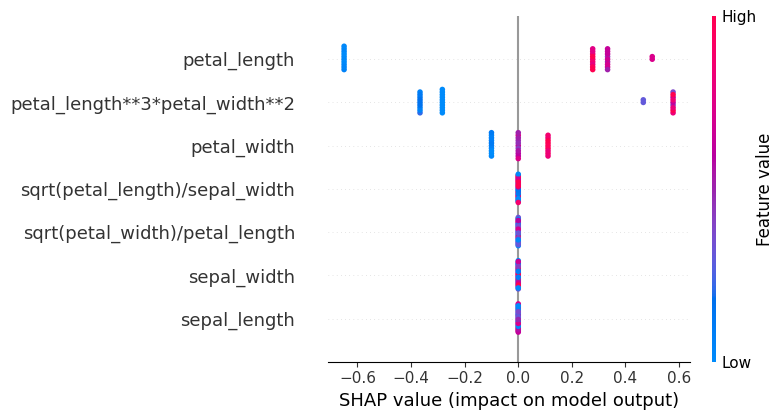

SHAP summary plot saved as 'shap_summary_plot.png'.
SHAP force plot saved as 'shap_force_plot.html'.


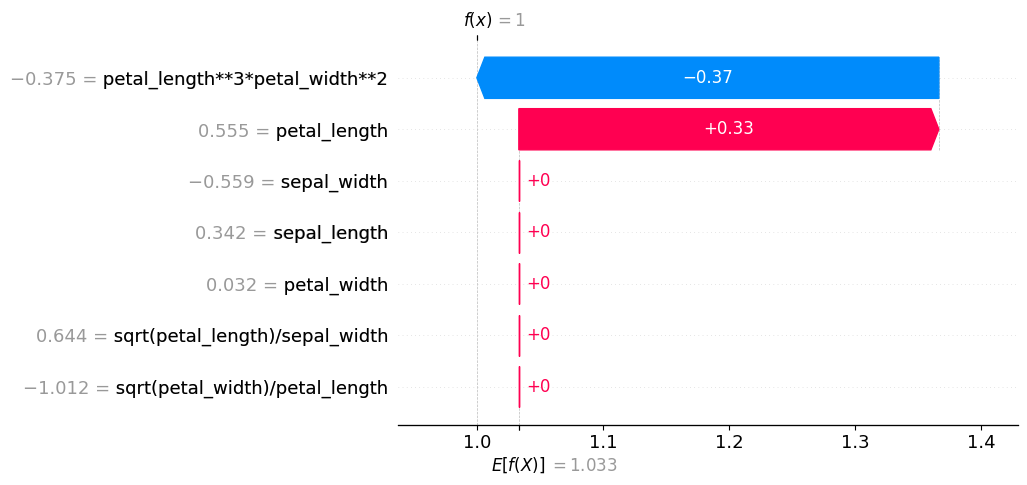

SHAP waterfall plot saved as 'shap_waterfall_plot.png'.


<Figure size 1000x600 with 0 Axes>

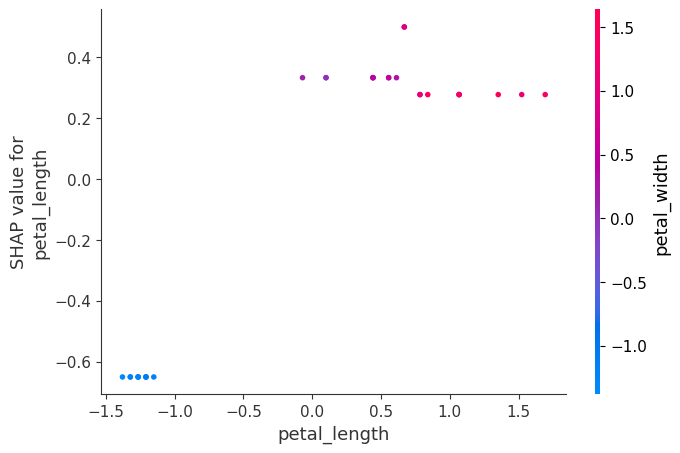

SHAP dependence plot saved as 'shap_dependence_plot.png'.


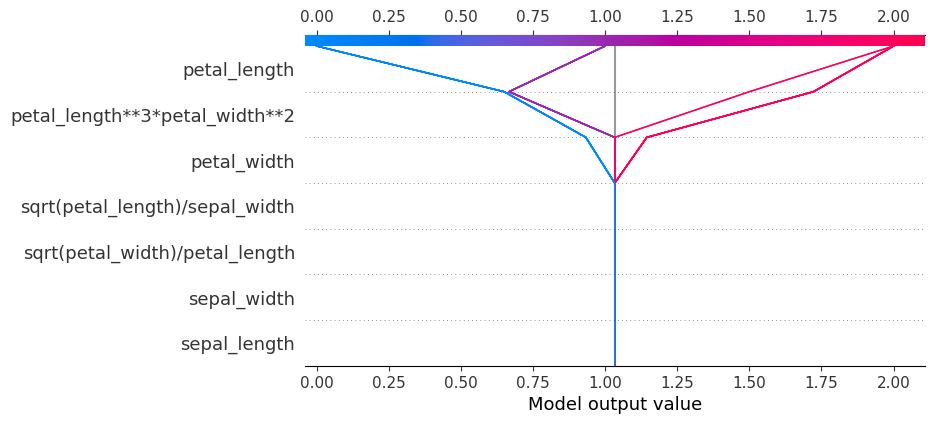

SHAP decision plot saved as 'shap_decision_plot.png'.
SHAP explainability applied.
Applying LIME for explainability...
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
LIME explanation saved as 'lime_explanation.html' for test sample index 0.
LIME explainability applied.
Shutting down H2O cluster...
H2O session _sid_967f closed.
H2O cluster shut down.
Process completed.


In [ ]:
# Step 7: Saving the model using h2o.save_model
print("Saving the best H2O AutoML model...")
save_model(best_model, "h2o_best_model")
print("Model saving completed.")

# Step 8: Apply SHAP for explainability
print("Applying SHAP for explainability...")
apply_shap_explainability(best_model, X_test_scaled)
print("SHAP explainability applied.")

# Step 9: Apply LIME for explainability
print("Applying LIME for explainability...")
apply_lime_explainability(best_model, X_train_scaled, X_test_scaled, y_train)
print("LIME explainability applied.")

# Step 10: Shut down the H2O cluster
print("Shutting down H2O cluster...")
shutdown_h2o()
print("Process completed.")

In [ ]:
import h2o
from h2o.automl import H2OAutoML
import os

# Initialize the H2O cluster
h2o.init()

# Path to your MOJO model (assuming it's uploaded or available in the local directory)
mojo_path = "h2o_best_model_mojo.zip"

# Load the MOJO model into the H2O cluster
mojo_model = h2o.import_mojo(mojo_path)

print("MOJO model loaded successfully")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.24" 2024-07-16; OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu322.04); OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu322.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmppeh0m10t
  JVM stdout: /tmp/tmppeh0m10t/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmppeh0m10t/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_unknownUser_9gqtfs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


generic Model Build progress: |██████████████████████████████████████████████████| (done) 100%
MOJO model loaded successfully


In [ ]:
import pandas as pd
from sklearn.datasets import load_iris

# Load the Iris dataset as a pandas DataFrame
iris = load_iris(as_frame=True)
iris_df = iris['data']

# Rename columns for clarity
iris_df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# Convert back to H2OFrame
iris_h2o_df_h2o = h2o.H2OFrame(X_test_scaled)


# Make predictions using the loaded MOJO model
predictions = mojo_model.predict(iris_h2o_df_h2o)

# Display the predictions
predictions.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
generic prediction progress: |███████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.10/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'exp(petal_length)': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.10/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'sqrt(petal_length)/sepal_width': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.10/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'sqrt(petal_width)/petal_length': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.10/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'log(petal_length)/petal_length': substituting in a column of NaN
  warnings.warn(w)


predict,p0,p1,p2
2,1.65027e-05,0.449707,0.550277
0,1,1.74965e-12,8.01652e-19
2,2.37225e-15,6.46253e-05,0.999935
1,2.87267e-06,0.920116,0.0798808
1,9.40718e-08,0.723844,0.276156
0,1,4.82139e-10,3.24452e-15
1,0.0011365,0.996311,0.00255225
2,3.2124e-11,2.46239e-05,0.999975
1,1.43302e-07,0.696684,0.303316
1,0.00014902,0.96375,0.036101


In [ ]:
predictions.as_data_frame(use_multi_thread=True).to_excel("tt.xlsx")

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
